In [71]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
from scipy.stats import mode

# import arviz as az
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import classification_report

numpyro.enable_x64()  # meant to improve performance


## Simulate some data:

Here I have simulated data so that the combined data has a mean of 0 when all three groups are combined and cluster centers are proportional to subgroup means as assumed by the model. 

/Users/victorlhoste/opt/anaconda3/envs/bayesian2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


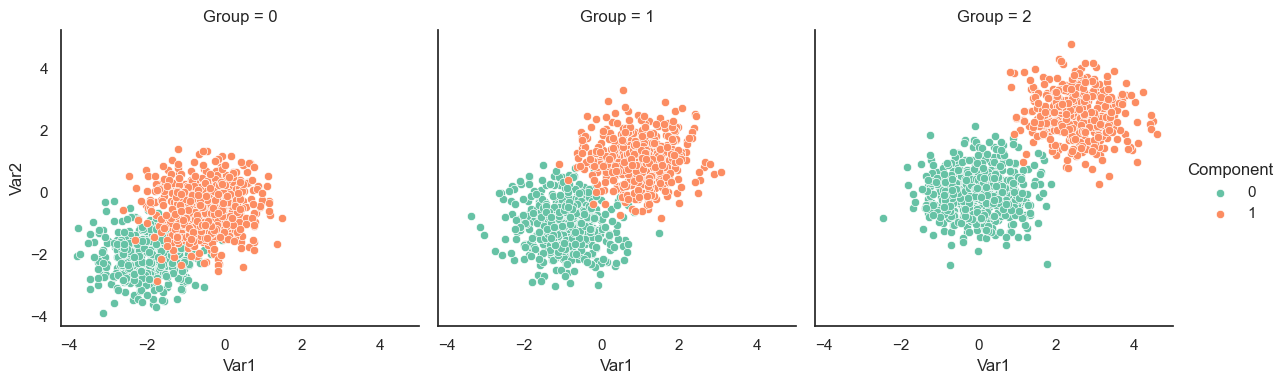

In [72]:
def generate_mixture_data(n, mixtures):
    data = np.zeros((n, 2))
    components = np.zeros(n, dtype=int)  # Array to store component labels

    for i in range(n):
        # Choose the component based on the given mixture probabilities
        component = np.random.choice(len(mixtures), p=[m[0] for m in mixtures])
        # Random sample from the chosen component
        mean = mixtures[component][1]
        data[i, :] = np.random.multivariate_normal(mean, 0.5 * np.eye(2))
        components[i] = component  # Store the component index

    return data, components


# Generate data for each group with component labels
group1_data, group1_components = generate_mixture_data(
    1000, [(1 / 3, [-2, -2]), (2 / 3, [-0.5, -0.5])]
)
group2_data, group2_components = generate_mixture_data(
    1000, [(0.5, [-1, -1]), (0.5, [1, 1])]
)
group3_data, group3_components = generate_mixture_data(
    1000, [(0.6, [0, 0]), (0.4, [2.5, 2.5])]
)

# Combine data into a single DataFrame
data = np.vstack((group1_data, group2_data, group3_data))
components = np.concatenate((group1_components, group2_components, group3_components))
df = pd.DataFrame(data, columns=["Var1", "Var2"])

# Add group and component labels
df["Group"] = [0] * 1000 + [1] * 1000 + [2] * 1000
df["Component"] = components

sns.set(style="white")

# Create a FacetGrid using Component as the color hue
g = sns.FacetGrid(
    df,
    col="Group",
    hue="Component",
    col_wrap=3,
    height=4,
    palette="Set2",
    legend_out=True,
)
g.map_dataframe(sns.scatterplot, x="Var1", y="Var2")
g.add_legend(title="Component")
g.set_axis_labels("Var1", "Var2")

plt.show()

In [73]:
mean_0 = df[df["Group"] == 0][["Var1", "Var2"]].mean()
mean_1 = df[df["Group"] == 1][["Var1", "Var2"]].mean()
mean_2 = df[df["Group"] == 2][["Var1", "Var2"]].mean()

means = jax.numpy.asarray([mean_0.to_numpy(), mean_1.to_numpy(), mean_2.to_numpy()])
means_ex = jnp.expand_dims(
    means, axis=1
)  # expanded to have a dimension for each cluster
print(means)

[[-1.06910633 -1.08757741]
 [-0.02802686 -0.04209642]
 [ 1.00637844  1.03794474]]


In [74]:
def Model_HGMM(K, dimension, data, label, means):
    """Define the hierarchical model for regression."""
    # Expanded means to match the dimensionality required for the model
    means_expanded = jnp.expand_dims(means, axis=1)
    means_repeated = jnp.repeat(means_expanded, K, axis=1)

    l = len(np.unique(label))

    with numpyro.plate("components", K):
        beta = numpyro.sample("beta", dist.Normal(1, 1))
        locs = numpyro.sample(
            "locs",
            dist.MultivariateNormal(jnp.zeros(dimension), 10 * jnp.eye(dimension)),
        )
        corr_mat = numpyro.sample("corr_mat", dist.LKJ(dimension, concentration=1))

    with numpyro.plate("Age group", l):
        cluster_proba = numpyro.sample("cluster_proba", dist.Dirichlet(jnp.ones(K)))

    sigma = numpyro.deterministic("sigma", 1 / K * corr_mat)
    beta_expanded = jnp.expand_dims(beta, axis=1)
    beta_repeated = jnp.repeat(beta_expanded, dimension, axis=1)
    locs_perturb_adjusted = numpyro.deterministic(
        "locs_perturb_adjusted", locs + beta_repeated * means_repeated
    )

    with numpyro.plate("data", len(data)):
        assignment = numpyro.sample(
            "assignment",
            dist.Categorical(cluster_proba[label]),
            infer={"enumerate": "parallel"},
        )
        numpyro.sample(
            "obs",
            dist.MultivariateNormal(
                locs_perturb_adjusted[label, assignment, :],
                covariance_matrix=sigma[assignment],
            ),
            obs=data,
        )

In [75]:
kernel = NUTS(Model_HGMM)
num_warmup, num_samples = 500, 1000
n_clusters = 2
n_variables = 2
data = df[["Var1", "Var2"]].to_numpy()
label = df[["Group"]].to_numpy().flatten()
mcmc = MCMC(  ## I could actually run several chains here and group by chains
    kernel, num_warmup=num_warmup, num_samples=num_samples
)

rng_key = jax.random.PRNGKey(10)
mcmc.warmup(
    rng_key,
    collect_warmup=True,
    K=n_clusters,
    dimension=n_variables,
    data=data,
    means=means,
    label=label,
)
mcmc.run(
    rng_key, K=n_clusters, dimension=n_variables, data=data, label=label, means=means
)

sample: 100%|██████████| 1000/1000 [00:11<00:00, 89.18it/s, 7 steps of size 6.02e-01. acc. prob=0.90]


In [76]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
           beta[0]      0.96      0.02      0.96      0.93      0.99   1193.64      1.00
           beta[1]      1.43      0.02      1.43      1.41      1.46   1535.15      1.00
cluster_proba[0,0]      0.38      0.02      0.38      0.35      0.41   1490.17      1.00
cluster_proba[0,1]      0.62      0.02      0.62      0.59      0.65   1490.17      1.00
cluster_proba[1,0]      0.51      0.02      0.51      0.48      0.54   1583.17      1.00
cluster_proba[1,1]      0.49      0.02      0.49      0.46      0.52   1583.17      1.00
cluster_proba[2,0]      0.59      0.02      0.59      0.56      0.61   1746.65      1.00
cluster_proba[2,1]      0.41      0.02      0.41      0.39      0.44   1746.65      1.00
   corr_mat[0,0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   corr_mat[0,0,1]     -0.02      0.03     -0.02     -0.07      0.03   1424.32      1.00
   corr_mat[0,1,0]  

In [77]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(Model_HGMM, posterior_samples, infer_discrete=True)

posterior_predictions = posterior_predictive(
    rng_key, K=n_clusters, dimension=n_variables, data=data, label=label, means=means
)

assignement = posterior_predictions["assignment"]

/Users/victorlhoste/opt/anaconda3/envs/bayesian2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


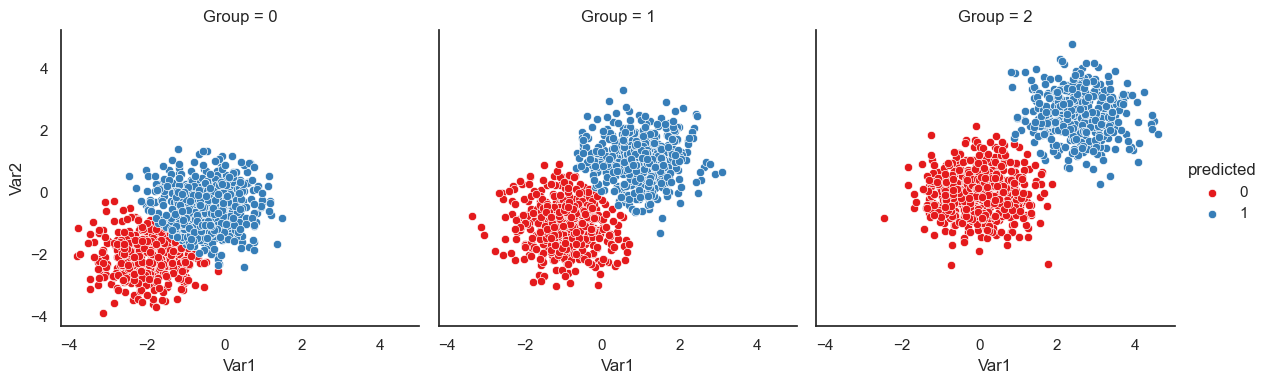

In [78]:
modes = mode(assignement, axis=0)
most_common_assignments = modes.mode
df["predicted"] = most_common_assignments

sns.set(style="white")

# Create a FacetGrid using Component as the color hue
g = sns.FacetGrid(
    df,
    col="Group",
    hue="predicted",
    col_wrap=3,
    height=4,
    palette="Set1",
    legend_out=True,
)
g.map_dataframe(sns.scatterplot, x="Var1", y="Var2")
g.add_legend(title="predicted")
g.set_axis_labels("Var1", "Var2")

plt.show()

/Users/victorlhoste/opt/anaconda3/envs/bayesian2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/81/b4cplk1j4x11rl7011b9bpx40000gn/T/ipykernel_95213/288326169.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  g.fig.colorbar(sm, label='Probability of Cluster 1')


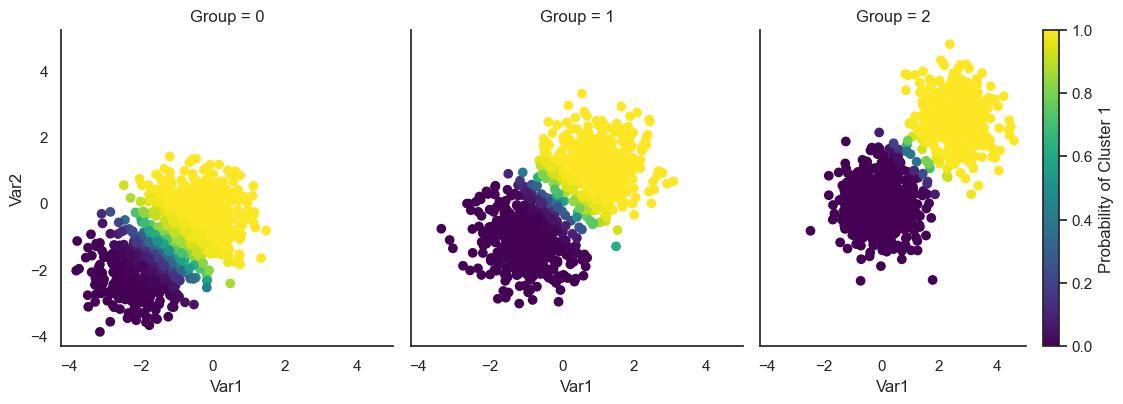

In [85]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

prob_cluster1 = np.mean(assignement == 1, axis=0)

# Convert this data into a DataFrame
df = pd.DataFrame(
    {
        "Var1": df["Var1"],
        "Var2": df["Var2"],
        "Group": df["Group"],
        "Component": df["Component"],
        "Proba_Cluster1": prob_cluster1,
    }
)

sns.set(style="white")

norm = Normalize(vmin=df["Proba_Cluster1"].min(), vmax=df["Proba_Cluster1"].max())

# Create a color mapping object using the colormap
cmap = viridis

# Create a ScalarMappable object with the normalization and colormap
sm = ScalarMappable(cmap=cmap, norm=norm)

# Create a FacetGrid without using the hue argument for coloring
g = sns.FacetGrid(df, col="Group", col_wrap=3, height=4)

# Use the DataFrame.apply method to apply a function along axis=1; this function plots each point individually
# and uses the ScalarMappable object to determine the color
g.map_dataframe(
    lambda data, color: plt.scatter(
        "Var1", "Var2", data=data, c=sm.to_rgba(data["Proba_Cluster1"])
    )
)

# Add a colorbar to the plot, which uses the ScalarMappable object
g.fig.colorbar(sm, label="Probability of Cluster 1")

g.set_axis_labels("Var1", "Var2")
g.fig.subplots_adjust(
    right=0.9
)  # Adjust the right edge of the plot to make space for the colorbar

plt.show()

In [79]:
actual = df["Component"]
predicted = df["predicted"]

# Compute Confusion Matrix
conf_matrix = confusion_matrix(actual, predicted)
print("Confusion Matrix:")
print(conf_matrix)

# Compute Accuracy
accuracy = accuracy_score(actual, predicted)
print("Accuracy: {:.2f}".format(accuracy))

# Compute Precision, Recall, and F1-Score
precision = precision_score(
    actual, predicted, average="weighted"
)  # Use 'macro' or 'weighted' for multi-class
recall = recall_score(actual, predicted, average="weighted")
f1 = f1_score(actual, predicted, average="weighted")

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

# Detailed classification report
class_report = classification_report(actual, predicted)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[1446   42]
 [  34 1478]]
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-Score: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1488
           1       0.97      0.98      0.97      1512

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000

